<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Using-non-Python-operations" data-toc-modified-id="Using-non-Python-operations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Using non-Python operations</a></span><ul class="toc-item"><li><span><a href="#External-executables" data-toc-modified-id="External-executables-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>External executables</a></span></li><li><span><a href="#Complex-external-operations-$-$-case-BDM" data-toc-modified-id="Complex-external-operations-$-$-case-BDM-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Complex external operations $-$ case BDM</a></span><ul class="toc-item"><li><span><a href="#Birth-Death-Mutation-process" data-toc-modified-id="Birth-Death-Mutation-process-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Birth-Death-Mutation process</a></span></li><li><span><a href="#Completing-the-BDM-model" data-toc-modified-id="Completing-the-BDM-model-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Completing the BDM model</a></span></li></ul></li><li><span><a href="#Interfacing-with-R" data-toc-modified-id="Interfacing-with-R-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Interfacing with R</a></span></li><li><span><a href="#Interfacing-with-MATLAB" data-toc-modified-id="Interfacing-with-MATLAB-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Interfacing with MATLAB</a></span></li><li><span><a href="#Verdict" data-toc-modified-id="Verdict-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Verdict</a></span><ul class="toc-item"><li><span><a href="#References" data-toc-modified-id="References-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>References</a></span></li></ul></li></ul></li></ul></div>

This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks). 

# Using non-Python operations

If your simulator or other operations are implemented in a programming language other than Python, you can still use ELFI. This notebook briefly demonstrates how to do this in three common scenarios:

* External executable (written e.g. in C++ or a shell script)
* R function
* MATLAB function

Let's begin by importing some libraries that we will be using:

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as ss

import elfi
import elfi.examples.bdm
import elfi.examples.ma2

%matplotlib inline

.. note:: To run some parts of this notebook you need to either compile the simulator, have R or MATLAB installed and install their respective wrapper libraries.

## External executables

ELFI supports using external simulators and other operations that can be called from the command-line. ELFI provides some tools to easily incorporate such operations to ELFI models. This functionality is introduced in this tutorial.

We demonstrate here how to wrap executables as ELFI nodes. We will first use `elfi.tools.external_operation` tool to wrap executables as a Python callables (function). Let's first investigate how it works with a simple shell `echo` command:

In [2]:
# Make an external command. {0} {1} are positional arguments and {seed} a keyword argument `seed`.
command = 'echo {0} {1} {seed}'
echo_sim = elfi.tools.external_operation(command)

# Test that `echo_sim` can now be called as a regular python function
echo_sim(3, 1, seed=123)

array([   3.,    1.,  123.])

The placeholders for arguments in the command string are just Python's [`format strings`](https://docs.python.org/3/library/string.html#formatstrings).

Currently `echo_sim` only accepts scalar arguments. In order to work in ELFI, `echo_sim` needs to be vectorized so that we can pass to it a vector of arguments. ELFI provides a handy tool for this as well:

In [3]:
# Vectorize it with elfi tools
echo_sim_vec = elfi.tools.vectorize(echo_sim)

# Make a simple model
m = elfi.ElfiModel(name='echo')
elfi.Prior('uniform', .005, 2, model=m, name='alpha')
elfi.Simulator(echo_sim_vec, m['alpha'], 0, name='echo')

# Test to generate 3 simulations from it
m['echo'].generate(3)

array([[  1.42711034e+00,   0.00000000e+00,   1.82207039e+09],
       [  4.79114659e-02,   0.00000000e+00,   1.82207039e+09],
       [  1.30307639e+00,   0.00000000e+00,   1.82207039e+09]])

So above, the first column draws from our uniform prior for $\alpha$, the second column has constant zeros, and the last one lists the seeds provided to the command by ELFI.

## Complex external operations $-$ case BDM

To provide a more realistic example of external operations, we will consider the Birth-Death-Mutation (BDM) model used in [*Lintusaari at al 2016*](https://doi.org/10.1093/sysbio/syw077) *[1]*.

### Birth-Death-Mutation process

We will consider here the Birth-Death-Mutation process simulator introduced in *Tanaka et al 2006 [2]* for the spread of Tuberculosis. The simulator outputs a count vector where each of its elements represents a "mutation" of the disease and the count describes how many are currently infected by that mutation. There are three rates and the population size:

- $\alpha$ - (birth rate) the rate at which any infectious host transmits the disease.
- $\delta$ - (death rate) the rate at which any existing infectious hosts either recovers or dies.
- $\tau$ - (mutation rate) the rate at which any infectious host develops a new unseen mutation of the disease within themselves.
- $N$ - (population size) the size of the simulated infectious population

It is assumed that the susceptible population is infinite, the hosts carry only one mutation of the disease and transmit that mutation onward. A more accurate description of the model can be found from the original paper or e.g. [*Lintusaari at al 2016*](https://doi.org/10.1093/sysbio/syw077) *[1]*.

<img src="resources/bdm.png" alt="BDM model illustration from Lintusaari et al. 2016" style="width: 400px;"/>

.. For documentation

.. image:: http://research.cs.aalto.fi/pml/software/elfi/docs/0.5/images/bdm.png
   :width: 400 px
   :alt: BDM model illustration from Lintusaari et al. 2016
   :align: center

This simulator cannot be implemented effectively with vectorized operations so we have implemented it with C++ that handles loops efficiently. We will now reproduce Figure 6(a) in [*Lintusaari at al 2016*](https://doi.org/10.1093/sysbio/syw077) *[2]* with ELFI. Let's start by defining some constants:

In [4]:
# Fixed model parameters
delta = 0
tau = 0.198
N = 20

# The zeros are to make the observed population vector have length N
y_obs = np.array([6, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='int16')

Let's build the beginning of a new model for the birth rate $\alpha$ as the only unknown

In [5]:
m = elfi.ElfiModel(name='bdm')
elfi.Prior('uniform', .005, 2, model=m, name='alpha')

Prior(name='alpha', 'uniform')

In [6]:
# Get the BDM source directory
sources_path = elfi.examples.bdm.get_sources_path()

# Compile (unix-like systems)
!make -C $sources_path

# Move the executable in to the working directory
!mv $sources_path/bdm .

make: Entering directory '/home/leclercq/codes/elfi/elfi/examples/cpp'
g++ bdm.cpp --std=c++0x -O -Wall -o bdm
make: Leaving directory '/home/leclercq/codes/elfi/elfi/examples/cpp'


.. note:: The source code for the BDM simulator comes with ELFI. You can get the directory with `elfi.examples.bdm.get_source_directory()`. Under unix-like systems it can be compiled with just typing `make` to console in the source directory. For windows systems, you need to have some C++ compiler available to compile it.

In [7]:
# Test the executable (assuming we have the executable `bdm` in the working directory)
sim = elfi.tools.external_operation('./bdm {0} {1} {2} {3} --seed {seed} --mode 1')
sim(1, delta, tau, N, seed=123)

array([ 19.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

The BDM simulator is actually already internally vectorized if you provide it an input file with parameters on the rows. This is more efficient than looping in Python (`elfi.tools.vectorize`), because one simulation takes very little time and we wish to generate tens of thousands of simulations. We will also here redirect the output to a file and then read the file into a numpy array. 

This is just one possibility among the many to implement this. The most efficient would be to write a native Python module with C++ but it's beyond the scope of this article. So let's work through files which is a fairly common situation especially with existing software.

In [8]:
# Assuming we have the executable `bdm` in the working directory
command = './bdm {filename} --seed {seed} --mode 1 > {output_filename}'


# Function to prepare the inputs for the simulator. We will create filenames and write an input file.
def prepare_inputs(*inputs, **kwinputs):
    alpha, delta, tau, N = inputs
    meta = kwinputs['meta']

    # Organize the parameters to an array. The broadcasting works nicely with constant arguments here.
    param_array = np.row_stack(np.broadcast(alpha, delta, tau, N))
    
    # Prepare a unique filename for parallel settings
    filename = '{model_name}_{batch_index}_{submission_index}.txt'.format(**meta)
    np.savetxt(filename, param_array, fmt='%.4f %.4f %.4f %d')

    # Add the filenames to kwinputs
    kwinputs['filename'] = filename
    kwinputs['output_filename'] = filename[:-4] + '_out.txt'
    
    # Return new inputs that the command will receive
    return inputs, kwinputs


# Function to process the result of the simulation
def process_result(completed_process, *inputs, **kwinputs):
    output_filename = kwinputs['output_filename']
    
    # Read the simulations from the file.
    simulations = np.loadtxt(output_filename, dtype='int16')
    
    # Clean up the files after reading the data in
    os.remove(kwinputs['filename'])
    os.remove(output_filename)
    
    # This will be passed to ELFI as the result of the command
    return simulations


# Create the python function (do not read stdout since we will work through files)
bdm = elfi.tools.external_operation(command, 
                                    prepare_inputs=prepare_inputs, 
                                    process_result=process_result, 
                                    stdout=False)

Now let's replace the echo simulator with this. To create unique but informative filenames, we ask ELFI to provide the operation some meta information. That will be available under the `meta` keyword (see the `prepare_inputs` function above):

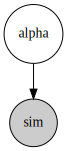

In [9]:
# Create the simulator
bdm_node = elfi.Simulator(bdm, m['alpha'], delta, tau, N, observed=y_obs, name='sim')

# Ask ELFI to provide the meta dict
bdm_node.uses_meta = True

# Draw the model
elfi.draw(m)

In [10]:
# Test it
data = bdm_node.generate(3)
print(data)

[[15  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  9  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  1  3  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


### Completing the BDM model

We are now ready to finish up the BDM model. To reproduce Figure 6(a) in [*Lintusaari at al 2016*](https://doi.org/10.1093/sysbio/syw077) *[2]*, let's add different summaries and discrepancies to the model and run the inference for each of them:

In [11]:
def T1(clusters):
    clusters = np.atleast_2d(clusters)
    return np.sum(clusters > 0, 1)/np.sum(clusters, 1)

def T2(clusters, n=20):
    clusters = np.atleast_2d(clusters)
    return 1 - np.sum((clusters/n)**2, axis=1)

# Add the different distances to the model
elfi.Summary(T1, bdm_node, name='T1')
elfi.Distance('minkowski', m['T1'], p=1, name='d_T1')

elfi.Summary(T2, bdm_node, name='T2')
elfi.Distance('minkowski', m['T2'], p=1, name='d_T2')

elfi.Distance('minkowski', m['sim'], p=1, name='d_sim')

Distance(name='d_sim')

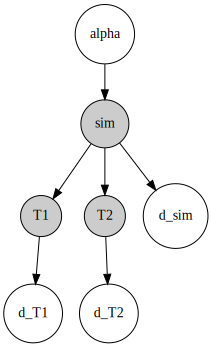

In [12]:
elfi.draw(m)

In [13]:
# Save parameter and simulation results in memory to speed up the later inference
pool = elfi.OutputPool(['alpha', 'sim'])
# Fix a seed
seed = 20170511

rej = elfi.Rejection(m, 'd_T1', batch_size=10000, pool=pool, seed=seed)
%time T1_res = rej.sample(5000, n_sim=int(1e5))

rej = elfi.Rejection(m, 'd_T2', batch_size=10000, pool=pool, seed=seed)
%time T2_res = rej.sample(5000, n_sim=int(1e5))

rej = elfi.Rejection(m, 'd_sim', batch_size=10000, pool=pool, seed=seed)
%time sim_res = rej.sample(5000, n_sim=int(1e5))

CPU times: user 2.13 s, sys: 36 ms, total: 2.16 s
Wall time: 2.82 s
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 21.3 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 24.7 ms


Results after 100000 simulations. Compare to figure 6(a) in Lintusaari et al. 2016.


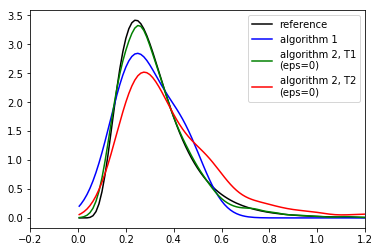

In [14]:
# Load a precomputed posterior based on an analytic solution (see Lintusaari et al 2016)
matdata = sio.loadmat('./resources/bdm.mat')
x = matdata['likgrid'].reshape(-1)
posterior_at_x = matdata['post'].reshape(-1)

# Plot the reference
plt.figure()
plt.plot(x, posterior_at_x, c='k')

# Plot the different curves
for res, d_node, c in ([sim_res, 'd_sim', 'b'], [T1_res, 'd_T1', 'g'], [T2_res, 'd_T2', 'r']):
    alphas = res.outputs['alpha']
    dists = res.outputs[d_node]
    # Use gaussian kde to make the curves look nice. Note that this tends to benefit the algorithm 1 
    # a lot as it ususally has only a very few accepted samples with 100000 simulations
    kde = ss.gaussian_kde(alphas[dists<=0])
    plt.plot(x, kde(x), c=c)
    
plt.legend(['reference', 'algorithm 1', 'algorithm 2, T1\n(eps=0)', 'algorithm 2, T2\n(eps=0)'])
plt.xlim([-.2, 1.2]);
print('Results after 100000 simulations. Compare to figure 6(a) in Lintusaari et al. 2016.')

## Interfacing with R

It is possible to run R scripts in command line for example with [Rscript](http://stat.ethz.ch/R-manual/R-devel/library/utils/html/Rscript.html). However, in Python it may be more convenient to use [rpy2](http://rpy2.readthedocs.io), which allows convenient access to the functionality of R from within Python. You can install it with `pip install rpy2`.

Here we demonstrate how to calculate the summary statistics used in the ELFI tutorial (autocovariances) using R's `acf` function for the MA2 model.

In [15]:
import rpy2.robjects as robj
from rpy2.robjects import numpy2ri as np2ri

# Converts numpy arrays automatically
np2ri.activate()

Let's create a Python function that wraps the R commands (please see the documentation of [rpy2](http://rpy2.readthedocs.io) for details):

In [16]:
robj.r('''
    # create a function `f`
    f <- function(x, lag=1) {
        ac = acf(x, plot=FALSE, type="covariance", lag.max=lag, demean=FALSE)
        ac[['acf']][lag+1]
    }
    ''')

f = robj.globalenv['f']

def autocovR(x, lag=1):
    x = np.atleast_2d(x)
    apply = robj.r['apply']
    ans = apply(x, 1, f, lag=lag)
    return np.atleast_1d(ans)

In [17]:
# Test it
autocovR(np.array([[1,2,3,4], [4,5,6,7]]), 1)

array([  5.,  23.])

Load a ready made MA2 model:

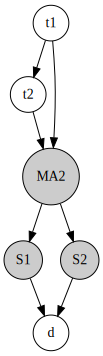

In [18]:
ma2 = elfi.examples.ma2.get_model(seed_obs=4)
elfi.draw(ma2)

Replace the summaries S1 and S2 with our R autocovariance function.

In [19]:
# Replace with R autocov
S1 = elfi.Summary(autocovR, ma2['MA2'], 1)
S2 = elfi.Summary(autocovR, ma2['MA2'], 2)
ma2['S1'].become(S1)
ma2['S2'].become(S2)

# Run the inference
rej = elfi.Rejection(ma2, 'd', batch_size=1000, seed=seed)
rej.sample(100)

Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 0.111
Sample means: t1: 0.599, t2: 0.177

## Interfacing with MATLAB

There are a number of options for running MATLAB (or Octave) scripts from within Python. Here, evaluating the distance is demonstrated with a MATLAB function using the official [MATLAB Python cd API](http://www.mathworks.com/help/matlab/matlab-engine-for-python.html). (Tested with MATLAB 2016b.)

In [20]:
import matlab.engine

A MATLAB session needs to be started (and stopped) separately:

In [21]:
eng = matlab.engine.start_matlab()  # takes a while...

Similarly as with R, we have to write a piece of code to interface between MATLAB and Python:

In [22]:
def euclidean_M(x, y):
    # MATLAB array initialized with Python's list
    ddM = matlab.double((x-y).tolist())
    
    # euclidean distance
    dM = eng.sqrt(eng.sum(eng.power(ddM, 2.0), 2))
    
    # Convert back to numpy array
    d = np.atleast_1d(dM).reshape(-1)
    return d

In [23]:
# Test it
euclidean_M(np.array([[1,2,3], [6,7,8], [2,2,3]]), np.array([2,2,2]))

array([ 1.41421356,  8.77496439,  1.        ])

Load a ready made MA2 model:

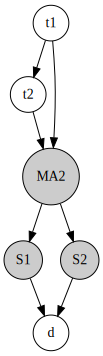

In [24]:
ma2M = elfi.examples.ma2.get_model(seed_obs=4)
elfi.draw(ma2M)

Replace the summaries S1 and S2 with our R autocovariance function.

In [25]:
# Replace with Matlab distance implementation
d = elfi.Distance(euclidean_M, ma2M['S1'], ma2M['S2'])
ma2M['d'].become(d)

# Run the inference
rej = elfi.Rejection(ma2M, 'd', batch_size=1000, seed=seed)
rej.sample(100)

Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 0.113
Sample means: t1: 0.602, t2: 0.178

Finally, don't forget to quit the MATLAB session:

In [26]:
eng.quit()

## Verdict

We showed here a few examples of how to incorporate non Python operations to ELFI models. There are multiple other ways to achieve the same results and even make the wrapping more efficient.

Wrapping often introduces some overhead to the evaluation of the generative model. In many cases however this is not an issue since the operations are usually expensive by themselves making the added overhead insignificant.

### References
- [1] Jarno Lintusaari, Michael U. Gutmann, Ritabrata Dutta, Samuel Kaski, Jukka Corander; Fundamentals and Recent Developments in Approximate Bayesian Computation. Syst Biol 2017; 66 (1): e66-e82. doi: 10.1093/sysbio/syw077
- [2] Tanaka, Mark M., et al. "Using approximate Bayesian computation to estimate
tuberculosis transmission parameters from genotype data."
Genetics 173.3 (2006): 1511-1520.
